In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from itertools import product

# Loading and Preparing Data

In [2]:
# Load the entire preprocessed dataset
pose_data = pd.read_csv('/kaggle/input/pose-samples/pose_data.csv')

## Load Data for Both Hands Only Classifier

6 classes * 12 regions * 70 samples per region per class = 5,040 samples

In [3]:
# Both-Hands Classifier
classes_both_hands = ["arms_crossed", "down", "head_both", "hips_both", "out_both", "up_both"]
pose_data_both_hands = pose_data[pose_data['label'].isin(classes_both_hands)].copy()

In [4]:
pose_data_both_hands

filepath         label  \
0      /kaggle/input/pose-samples/dataset/hips_both/2...     hips_both   
1      /kaggle/input/pose-samples/dataset/hips_both/1...     hips_both   
2      /kaggle/input/pose-samples/dataset/hips_both/2...     hips_both   
3      /kaggle/input/pose-samples/dataset/hips_both/5...     hips_both   
4      /kaggle/input/pose-samples/dataset/hips_both/1...     hips_both   
...                                                  ...           ...   
10075  /kaggle/input/pose-samples/dataset/arms_crosse...  arms_crossed   
10076  /kaggle/input/pose-samples/dataset/arms_crosse...  arms_crossed   
10077  /kaggle/input/pose-samples/dataset/arms_crosse...  arms_crossed   
10078  /kaggle/input/pose-samples/dataset/arms_crosse...  arms_crossed   
10079  /kaggle/input/pose-samples/dataset/arms_crosse...  arms_crossed   

       keypoint_1_x  keypoint_1_y  keypoint_1_confidence  keypoint_2_x  \
0          0.157232      0.465951               0.639461      0.131719   
1          0.315034      0.621453               0.521858      0.304798   
2          0.154952      0.467593               0.647912      0.129939   
3          0.249982      0.477067               0.492132      0.231826   
4          0.330230      0.376159               0.479052      0.317904   
...             ...           ...                    ...           ...   
10075      0.231840      0.673985               0.640640      0.210863   
10076      0.159256      0.728072               0.716234      0.128298   
10077      0.290467      0.645833               0.670768      0.277512   
10078      0.320809      0.496387               0.654436      0.309098   
10079      0.257446      0.508950               0.662293      0.239832   

       keypoint_2_y  keypoint_2_confidence  keypoint_3_x  keypoint_3_y  ...  \
0          0.488206               0.753154      0.132580      0.452213  ...   
1          0.633559               0.794087      0.302751      0.616457  ...   
2          0.489996               0.779076      0.131025      0.452670  ...   
3          0.493374               0.577322      0.233285      0.468433  ...   
4          0.386573               0.676289      0.319590      0.368453  ...   
...             ...                    ...           ...           ...  ...   
10075      0.691873               0.739287      0.212461      0.663128  ...   
10076      0.747793               0.468243      0.138150      0.707776  ...   
10077      0.657766               0.521265      0.276537      0.634750  ...   
10078      0.507291               0.666624      0.308165      0.492230  ...   
10079      0.523068               0.750915      0.240467      0.494325  ...   

       keypoint_14_confidence  keypoint_15_x  keypoint_15_y  \
0                    0.744075       0.852234       0.444346   
1                    0.628779       0.727164       0.601154   
2                    0.727519       0.859035       0.444763   
3                    0.548012       0.802862       0.470187   
4                    0.340373       0.717624       0.354151   
...                       ...            ...            ...   
10075                0.544862       0.855322       0.641863   
10076                0.462922       0.962264       0.704897   
10077                0.415768       0.780932       0.623476   
10078                0.472728       0.698306       0.463848   
10079                0.549725       0.816609       0.470411   

       keypoint_15_confidence  keypoint_16_x  keypoint_16_y  \
0                    0.567248       0.984105       0.540210   
1                    0.470642       0.878457       0.652062   
2                    0.499444       0.985067       0.541248   
3                    0.452560       0.987729       0.552953   
4                    0.548687       0.864508       0.431009   
...                       ...            ...            ...   
10075                0.594385       0.998420       0.744073   
10076                0.544980       1.053077       0.811724 

## Prepare Data for Both-Hands-Only Classifier

In [5]:
# Extract features and labels
X_both = pose_data_both_hands.filter(like='keypoint').values
y_both = pose_data_both_hands['label'].values

# Encode labels
label_encoder_both = LabelEncoder()
y_encoded_both = label_encoder_both.fit_transform(y_both)
y_one_hot_both = to_categorical(y_encoded_both)  # Convert to one-hot encoding

## Load Data for Direction-Agnostic Classifier

10 classes * 12 regions * 70 samples per region per class = 8,400 samples

In [6]:
# Function to create direction-agnostic data
def create_direction_agnostic_data(pose_data, directional_classes, new_label):
    merged_data = []
    for label in directional_classes:
        subset = pose_data[pose_data['label'] == label]
        sampled = subset.sample(frac=0.5, random_state=42)
        merged_data.append(sampled)
    merged_data = pd.concat(merged_data)
    merged_data['label'] = new_label
    return merged_data

In [7]:
# Add "both-hands" data
classes_one_or_both_agnostic = ["arms_crossed", "down", "head_both", "hips_both", "out_both", "up_both"]
agnostic_data = pose_data[pose_data['label'].isin(classes_one_or_both_agnostic)].copy()

In [8]:
# Add direction-agnostic "one-hand" data
head_one = create_direction_agnostic_data(pose_data, ["head_left", "head_right"], "head_one")
hips_one = create_direction_agnostic_data(pose_data, ["hips_left", "hips_right"], "hips_one")
out_one = create_direction_agnostic_data(pose_data, ["out_left", "out_right"], "out_one")
up_one = create_direction_agnostic_data(pose_data, ["up_left", "up_right"], "up_one")

In [9]:
# Combine the original agnostic data with the "one-hand" data
pose_data_agnostic = pd.concat([agnostic_data, head_one, hips_one, out_one, up_one], ignore_index=True)

In [10]:
pose_data_agnostic

filepath      label  \
0     /kaggle/input/pose-samples/dataset/hips_both/2...  hips_both   
1     /kaggle/input/pose-samples/dataset/hips_both/1...  hips_both   
2     /kaggle/input/pose-samples/dataset/hips_both/2...  hips_both   
3     /kaggle/input/pose-samples/dataset/hips_both/5...  hips_both   
4     /kaggle/input/pose-samples/dataset/hips_both/1...  hips_both   
...                                                 ...        ...   
8395  /kaggle/input/pose-samples/dataset/up_right/3_...     up_one   
8396  /kaggle/input/pose-samples/dataset/up_right/12...     up_one   
8397  /kaggle/input/pose-samples/dataset/up_right/5_...     up_one   
8398  /kaggle/input/pose-samples/dataset/up_right/9_...     up_one   
8399  /kaggle/input/pose-samples/dataset/up_right/6_...     up_one   

      keypoint_1_x  keypoint_1_y  keypoint_1_confidence  keypoint_2_x  \
0         0.157232      0.465951               0.639461      0.131719   
1         0.315034      0.621453               0.521858      0.304798   
2         0.154952      0.467593               0.647912      0.129939   
3         0.249982      0.477067               0.492132      0.231826   
4         0.330230      0.376159               0.479052      0.317904   
...            ...           ...                    ...           ...   
8395      0.172612      0.231353               0.579712      0.146786   
8396      0.320756      0.378745               0.594074      0.308571   
8397      0.255427      0.497181               0.563727      0.238174   
8398      0.286903      0.353725               0.581977      0.273437   
8399      0.262355      0.318086               0.571871      0.245278   

      keypoint_2_y  keypoint_2_confidence  keypoint_3_x  keypoint_3_y  ...  \
0         0.488206               0.753154      0.132580      0.452213  ...   
1         0.633559               0.794087      0.302751      0.616457  ...   
2         0.489996               0.779076      0.131025      0.452670  ...   
3         0.493374               0.577322      0.233285      0.468433  ...   
4         0.386573               0.676289      0.319590      0.368453  ...   
...            ...                    ...           ...           ...  ...   
8395      0.249922               0.618347      0.150005      0.210270  ...   
8396      0.386863               0.559001      0.308632      0.369708  ...   
8397      0.512376               0.526201      0.236840      0.485581  ...   
8398      0.365739               0.779182      0.274455      0.343268  ...   
8399      0.332304               0.705078      0.246277      0.307176  ...   

      keypoint_14_confidence  keypoint_15_x  keypoint_15_y  \
0                   0.744075       0.852234       0.444346   
1                   0.628779       0.727164       0.601154   
2                   0.727519       0.859035       0.444763   
3                   0.548012       0.802862       0.470187   
4                   0.340373       0.717624       0.354151   
...                      ...            ...            ...   
8395                0.492535       0.978643       0.181274   
8396                0.570954       0.715000       0.358109   
8397                0.599505       0.825750       0.465881   
8398                0.598165       0.774405       0.320965   
8399                0.377098       0.855279       0.292830   

      keypoint_15_confidence  keypoint_16_x  keypoint_16_y  \
0                   0.567248       0.984105       0.540210   
1                   0.470642       0.878457       0.652062   
2                   0.499444       0.985067       0.541248   
3                   0.452560       0.987729       0.552953   
4                   0.548687       0.864508       0.431009   
...                      ...            ...            ...   
8395                0.414817       1.048523       0.303412   
8396                0.529099       0.864424       0.408810   
8397                0.497442       0.997820       0.560777   
8398                0.57627

## Prepare Data for Direction-Agnostic Classifier

In [11]:
# Extract features and labels
X_agnostic = pose_data_agnostic.filter(like='keypoint').values
y_agnostic = pose_data_agnostic['label'].values

# Encode labels
label_encoder_agnostic = LabelEncoder()
y_encoded_agnostic = label_encoder_agnostic.fit_transform(y_agnostic)
y_one_hot_agnostic = to_categorical(y_encoded_agnostic)  # Convert to one-hot encoding

## Load Data for Direction-Cognizant Classifier

14 classes * 12 regions * 70 samples per region per class = 11,760 samples

In [12]:
# Direction-Cognizant Classifier
classes_one_or_both_cognizant = [
    "arms_crossed", "down", "head_both", "head_left", "head_right", "hips_both", "hips_left",
    "hips_right", "out_both", "out_left", "out_right", "up_both", "up_left", "up_right"
]
pose_data_cognizant = pose_data[pose_data['label'].isin(classes_one_or_both_cognizant)].copy()

In [13]:
pose_data_cognizant

filepath      label  \
0      /kaggle/input/pose-samples/dataset/hips_both/2...  hips_both   
1      /kaggle/input/pose-samples/dataset/hips_both/1...  hips_both   
2      /kaggle/input/pose-samples/dataset/hips_both/2...  hips_both   
3      /kaggle/input/pose-samples/dataset/hips_both/5...  hips_both   
4      /kaggle/input/pose-samples/dataset/hips_both/1...  hips_both   
...                                                  ...        ...   
11755  /kaggle/input/pose-samples/dataset/head_left/2...  head_left   
11756  /kaggle/input/pose-samples/dataset/head_left/4...  head_left   
11757  /kaggle/input/pose-samples/dataset/head_left/1...  head_left   
11758  /kaggle/input/pose-samples/dataset/head_left/1...  head_left   
11759  /kaggle/input/pose-samples/dataset/head_left/7...  head_left   

       keypoint_1_x  keypoint_1_y  keypoint_1_confidence  keypoint_2_x  \
0          0.157232      0.465951               0.639461      0.131719   
1          0.315034      0.621453               0.521858      0.304798   
2          0.154952      0.467593               0.647912      0.129939   
3          0.249982      0.477067               0.492132      0.231826   
4          0.330230      0.376159               0.479052      0.317904   
...             ...           ...                    ...           ...   
11755      0.161448      0.493945               0.754320      0.135180   
11756      0.238051      0.696721               0.587554      0.222458   
11757      0.323418      0.490358               0.611177      0.315017   
11758      0.323138      0.373149               0.542986      0.308982   
11759      0.279609      0.650143               0.625301      0.263665   

       keypoint_2_y  keypoint_2_confidence  keypoint_3_x  keypoint_3_y  ...  \
0          0.488206               0.753154      0.132580      0.452213  ...   
1          0.633559               0.794087      0.302751      0.616457  ...   
2          0.489996               0.779076      0.131025      0.452670  ...   
3          0.493374               0.577322      0.233285      0.468433  ...   
4          0.386573               0.676289      0.319590      0.368453  ...   
...             ...                    ...           ...           ...  ...   
11755      0.513979               0.600848      0.134714      0.474764  ...   
11756      0.712427               0.685830      0.218109      0.684135  ...   
11757      0.502242               0.531157      0.309086      0.484949  ...   
11758      0.382088               0.583977      0.313260      0.364622  ...   
11759      0.663191               0.479969      0.264494      0.640347  ...   

       keypoint_14_confidence  keypoint_15_x  keypoint_15_y  \
0                    0.744075       0.852234       0.444346   
1                    0.628779       0.727164       0.601154   
2                    0.727519       0.859035       0.444763   
3                    0.548012       0.802862       0.470187   
4                    0.340373       0.717624       0.354151   
...                       ...            ...            ...   
11755                0.306998       0.908860       0.446123   
11756                0.787437       0.847922       0.647427   
11757                0.626327       0.721673       0.462727   
11758                0.472405       0.730352       0.358235   
11759                0.556251       0.779932       0.624105   

       keypoint_15_confidence  keypoint_16_x  keypoint_16_y  \
0                    0.567248       0.984105       0.540210   
1                    0.470642       0.878457       0.652062   
2                    0.499444       0.985067       0.541248   
3                    0.452560       0.987729       0.552953   
4                    0.548687       0.864508       0.431009   
...                       ...            ...            ...   
11755                0.436176       1.003963       0.550535   
11756                0.641945       1.002997       0.715981   
11757                0.379882    

## Prepare Data for Direction-Cognizant Classifier

In [14]:
# Extract features and labels
X_cognizant = pose_data_cognizant.filter(like='keypoint').values
y_cognizant = pose_data_cognizant['label'].values

# Encode labels
label_encoder_cognizant = LabelEncoder()
y_encoded_cognizant = label_encoder_cognizant.fit_transform(y_cognizant)
y_one_hot_cognizant = to_categorical(y_encoded_cognizant)  # Convert to one-hot encoding

## Split Data for Model Training and Evaluation

In [15]:
# Encapsulate train_test_split function for readability
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X,
                            y,
                            test_size=test_size,
                            random_state=random_state,
                            stratify=y)

In [16]:
# Split for Both-Hands Classifier
X_both_train, X_both_test, y_both_train, y_both_test = split_data(X_both, y_one_hot_both)

In [17]:
print(X_both_train.shape, X_both_test.shape)
print(y_both_train.shape, y_both_test.shape)

(4032, 51) (1008, 51)
(4032, 6) (1008, 6)


In [18]:
# Split for Direction-Agnostic Classifier
X_agnostic_train, X_agnostic_test, y_agnostic_train, y_agnostic_test = split_data(X_agnostic, y_one_hot_agnostic)

In [19]:
print(X_agnostic_train.shape, X_agnostic_test.shape)
print(y_agnostic_train.shape, y_agnostic_test.shape)

(6720, 51) (1680, 51)
(6720, 10) (1680, 10)


In [20]:
# Split for Direction-Cognizant Classifier
X_cognizant_train, X_cognizant_test, y_cognizant_train, y_cognizant_test = split_data(X_cognizant, y_one_hot_cognizant)

In [21]:
print(X_cognizant_train.shape, X_cognizant_test.shape)
print(y_cognizant_train.shape, y_cognizant_test.shape)

(9408, 51) (2352, 51)
(9408, 14) (2352, 14)


# Model Training

## Sample Model Structure

In [22]:
sample_model = Sequential([
    Input(shape=(51,)), # Input layer (always [51])
    Dense(128, activation=tf.nn.relu6),
    Dropout(0.5),
    Dense(64, activation=tf.nn.relu6),
    Dropout(0.5),
    Dense(6, activation="softmax") # Output layer (depends on number of classes)
])

In [23]:
# Compile the model
sample_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
sample_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,302 (59.77 KB)

 Trainable params: 15,302 (59.77 KB)

 Non-trainable params: 0 (0.00 B)

## Dynamic Training Setup

### Model Creation Function

In [24]:
def create_model(input_shape, output_classes, dropout_rate, learning_rate):
    """Creates a feed-forward neural network."""
    model = Sequential([
        Input(shape=(input_shape,)), # Input layer (always [51])
        Dense(128, activation=tf.nn.relu6),
        Dropout(dropout_rate),
        Dense(64, activation=tf.nn.relu6),
        Dropout(dropout_rate),
        Dense(output_classes, activation="softmax") # Output layer (depends on number of classes)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### K-fold Cross-Validation Function

In [25]:
def k_fold_cv(X, y, param_dict, classifier_name, n_splits, epochs, batch_size, dropout_rate, learning_rate):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []
    best_model = None
    best_accuracy = 0
    best_fold = None
    best_history = None  # To store the history of the best model

    # Generate a prefix based on classifier name and parameter combination
    param_prefix = "_".join(f"{key}-{value}" for key, value in param_dict.items())
    filename_prefix = f"{classifier_name}_{param_prefix}"

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, np.argmax(y, axis=1))):
        print(f"\nTraining Fold {fold + 1}/{n_splits}")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Create model
        model = create_model(input_shape=X.shape[1], output_classes=y.shape[1],
                             dropout_rate=dropout_rate, learning_rate=learning_rate)

        # Define callbacks (only EarlyStopping now)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        history = model.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            epochs=epochs, 
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=1)
        
        # Evaluate on validation data
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        fold_accuracies.append(val_accuracy)
        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")

        # Track the best model
        if val_accuracy > best_accuracy:
            best_model = model
            best_accuracy = val_accuracy
            best_fold = fold + 1
            best_history = history  # Save the history of the best model

    # Save the best model with the classifier name in the filename
    if best_model:
        filename = f"{filename_prefix}_best_model.keras"
        best_model.save(filename)
        print(f"\nBest model from Fold {best_fold} saved as '{filename}'.")

    print(f"\nAverage Validation Accuracy across folds: {np.mean(fold_accuracies):.4f}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    return best_model, best_history, fold_accuracies

### Grid Search Hyperparameter Tuning

In [26]:
# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [96, 128]
}

In [27]:
def grid_search(X, y, classifier_name, n_splits, epochs):
    results = []  # To store performance metrics for each parameter combination
    best_model = None
    best_history = None  # Store the history of the best model
    best_accuracy = 0
    best_params = None

    # Iterate over all combinations of hyperparameters
    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"\nTesting parameters: {param_dict}")

        # Perform k-fold cross-validation
        model, history, fold_accuracies = k_fold_cv(
            X, y,
            param_dict=param_dict,
            n_splits=n_splits,
            epochs=epochs,
            batch_size=param_dict['batch_size'],
            dropout_rate=param_dict['dropout_rate'],
            learning_rate=param_dict['learning_rate'],
            classifier_name=classifier_name  # Pass classifier name to k_fold_cv
        )

        # Compute average accuracy
        avg_accuracy = np.mean(fold_accuracies)
        print(f"Average Validation Accuracy for parameters {param_dict}: {avg_accuracy:.4f}")

        # Log the results
        results.append({
            **param_dict,
            'avg_accuracy': avg_accuracy,
            'fold_accuracies': fold_accuracies
        })

        # Update the best model
        if avg_accuracy > best_accuracy:
            best_model = model
            best_history = history  # Save the history of the best model
            best_accuracy = avg_accuracy
            best_params = param_dict

    # Save results to a DataFrame for visualization
    results_df = pd.DataFrame(results)
    results_file = f"{classifier_name}_grid_search_results.csv"
    results_df.to_csv(results_file, index=False)
    print(f"\nResults saved to '{results_file}'.")

    print(f"\nBest Parameters: {best_params}")
    print(f"Best Average Validation Accuracy: {best_accuracy:.4f}")
    return best_model, best_history, best_params, results_df

## Training the Models
Performing hyperparameter tuning, saving the best model, the best parameters, and the results for all parameters checked

### Both Hands, 6 classes

In [28]:
# Run grid search for both hands model
best_model_both, best_history_both, best_params_both, results_both = grid_search(
    X_both_train,
    y_both_train,
    n_splits=5,
    epochs=128,
    classifier_name='both'
)


Testing parameters: {'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 96}

Training Fold 1/5
Epoch 1/128


I0000 00:00:1733091106.071554     373 service.cc:145] XLA service 0x7be2f00053a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733091106.071609     373 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733091106.071614     373 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:38 5s/step - accuracy: 0.1562 - loss: 1.8250

I0000 00:00:1733091109.944926     373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.2161 - loss: 1.7791 - val_accuracy: 0.5390 - val_loss: 1.6158
Epoch 2/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4128 - loss: 1.5757 - val_accuracy: 0.6840 - val_loss: 1.2955
Epoch 3/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5276 - loss: 1.2811 - val_accuracy: 0.7633 - val_loss: 1.0181
Epoch 4/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6202 - loss: 1.0433 - val_accuracy: 0.8501 - val_loss: 0.8144
Epoch 5/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6929 - loss: 0.8630 - val_accuracy: 0.8662 - val_loss: 0.6557
Epoch 6/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.7242 - val_accuracy: 0.8872 - val_loss: 0.5586
Epoch 7/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7915 - loss: 0.6325 - val_accuracy: 0.9343 - val_loss: 0.4363
Epoch 8/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.5167 - val_accuracy: 0.9678 - val_loss: 0

In [29]:
best_model_both.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,908 (179.33 KB)

 Trainable params: 15,302 (59.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,606 (119.56 KB)

In [30]:
best_model_both.save('best_both.keras')

### Both Hands + One Hand (direction-agnostic), 10 classes

In [ ]:
# Run grid search for both hands + one hand agnostic model
best_model_agnostic, best_history_agnostic, best_params_agnostic, results_agnostic = grid_search(
    X_agnostic_train,
    y_agnostic_train,
    n_splits=5,
    epochs=128,
    classifier_name='agnostic'
)


Testing parameters: {'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 96}

Training Fold 1/5
Epoch 1/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1180 - loss: 2.3462 - val_accuracy: 0.2567 - val_loss: 2.2101
Epoch 2/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2148 - loss: 2.1843 - val_accuracy: 0.3765 - val_loss: 1.9535
Epoch 3/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3256 - loss: 1.9119 - val_accuracy: 0.5298 - val_loss: 1.6142
Epoch 4/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4173 - loss: 1.6315 - val_accuracy: 0.5811 - val_loss: 1.3533
Epoch 5/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4921 - loss: 1.3914 - val_accuracy: 0.6369 - val_loss: 1.1746
Epoch 6/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5481 - loss: 1.2443 - val_accuracy: 0.7440 - val_loss: 1.0223
Epoch 7/128
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5799 - loss: 1.1239 - val_accuracy: 0.7850 - val_loss: 0.8825
Epoch 8

In [43]:
best_model_agnostic.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,688 (182.38 KB)

 Trainable params: 15,562 (60.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,126 (121.59 KB)

In [ ]:
best_model_agnostic.save('best_agnostic.keras')

### Both Hands + One Hand (direction-cognizant), 14 classes

In [ ]:
# Run grid search for both hands + one hand cognizant model
best_model_cognizant, best_history_cognizant, best_params_cognizant, results_cognizant = grid_search(
    X_cognizant_train,
    y_cognizant_train,
    n_splits=5,
    epochs=128,
    classifier_name='cognizant'
)

In [44]:
best_model_cognizant.summary()

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_261 (Dense)               │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,468 (185.43 KB)

 Trainable params: 15,822 (61.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,646 (123.62 KB)

In [ ]:
best_model_cognizant.save('best_cognizant.keras')

## Results and Evaluation on Test

In [45]:
# Display results for each classifier
print("Both Hands Classifier Results:")
print(results_both.sort_values(by='avg_accuracy', ascending=False))

print("\nAgnostic Classifier Results:")
print(results_agnostic.sort_values(by='avg_accuracy', ascending=False))

print("\nCognizant Classifier Results:")
print(results_cognizant.sort_values(by='avg_accuracy', ascending=False))

Both Hands Classifier Results:
   dropout_rate  learning_rate  batch_size  avg_accuracy  \
0           0.2         0.0010          96      0.999008   
1           0.2         0.0010         128      0.998512   
4           0.5         0.0010          96      0.998016   
5           0.5         0.0010         128      0.996776   
2           0.2         0.0001          96      0.990575   
3           0.2         0.0001         128      0.987104   
6           0.5         0.0001          96      0.971971   
7           0.5         0.0001         128      0.961559   

                                     fold_accuracies  
0  [0.9987608194351196, 0.9987608194351196, 1.0, ...  
1  [0.997521698474884, 1.0, 1.0, 0.99751859903335...  
4  [0.997521698474884, 0.9987608194351196, 1.0, 0...  
5  [0.9962825179100037, 0.997521698474884, 0.9987...  
2  [0.9925650358200073, 0.9888476133346558, 0.991...  
3  [0.983890950679779, 0.9851301312446594, 0.9888...  
6  [0.9764559864997864, 0.9789343476295471,

### Loss and Accuracy Graphs

In [47]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

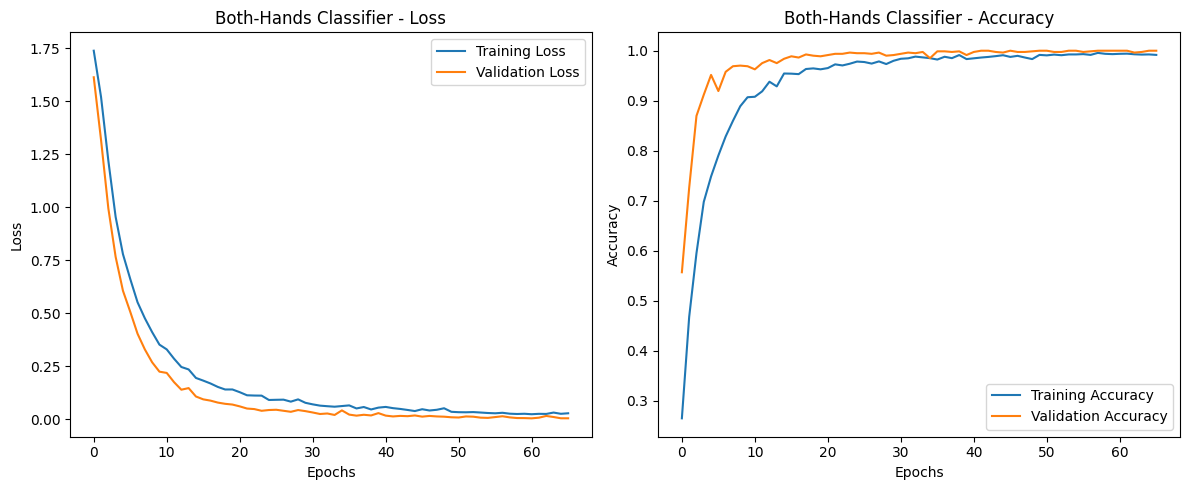

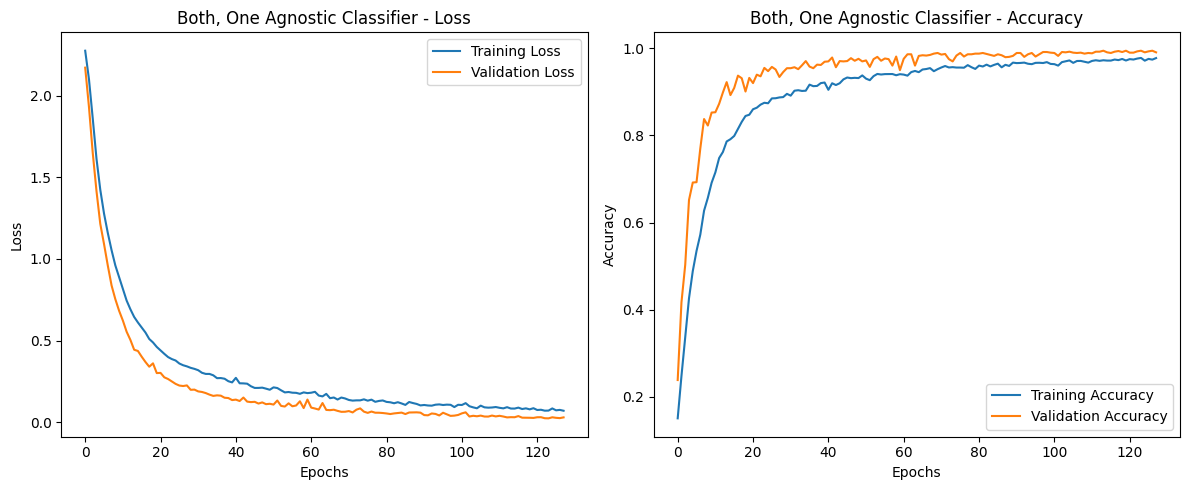

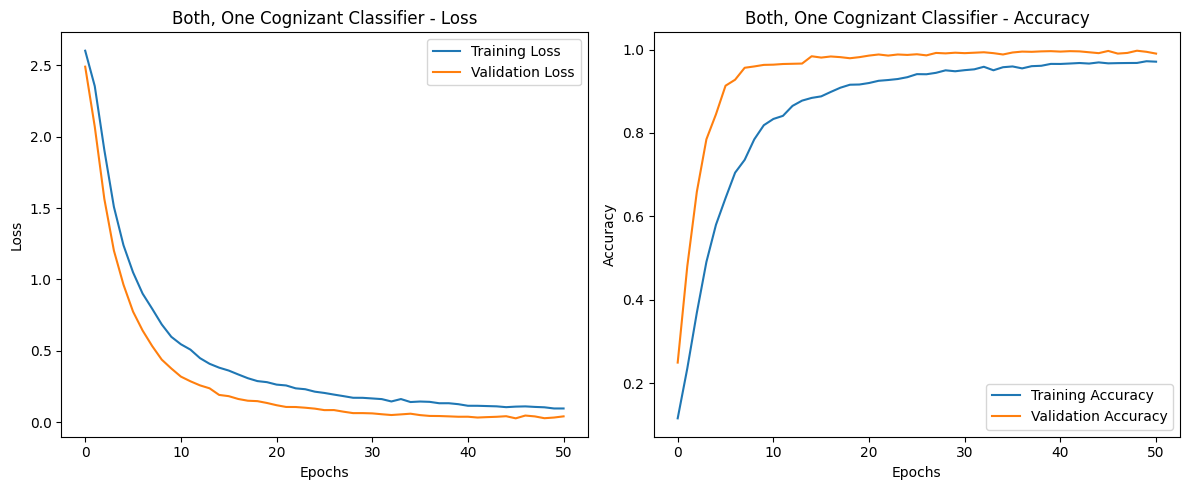

In [48]:
plot_loss_accuracy(best_history_both, title="Both-Hands Classifier")

plot_loss_accuracy(best_history_agnostic, title="Both, One Agnostic Classifier")

plot_loss_accuracy(best_history_cognizant, title="Both, One Cognizant Classifier")

### Precision-Recall Curves

In [49]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

def plot_precision_recall(model, X_test, y_test, classes):
    """
    Plot Precision-Recall curves for a multi-class classification model.
    
    Args:
        model: Trained model (e.g., Keras or TensorFlow model).
        X_test: Test features (numpy array or DataFrame).
        y_test: True labels in one-hot encoded format (numpy array).
        classes: List of class names corresponding to y_test columns.

    Returns:
        None. Displays a plot.
    """
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices
    y_scores = model.predict(X_test)  # Predicted probabilities for each class
    y_true_binarized = label_binarize(y_true, classes=np.arange(len(classes)))

    plt.figure(figsize=(10, 7))

    # Generate a precision-recall curve for each class
    for i, class_name in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_scores[:, i])
        plt.plot(recall, precision, label=f"Class {class_name}")

    # Plot settings
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


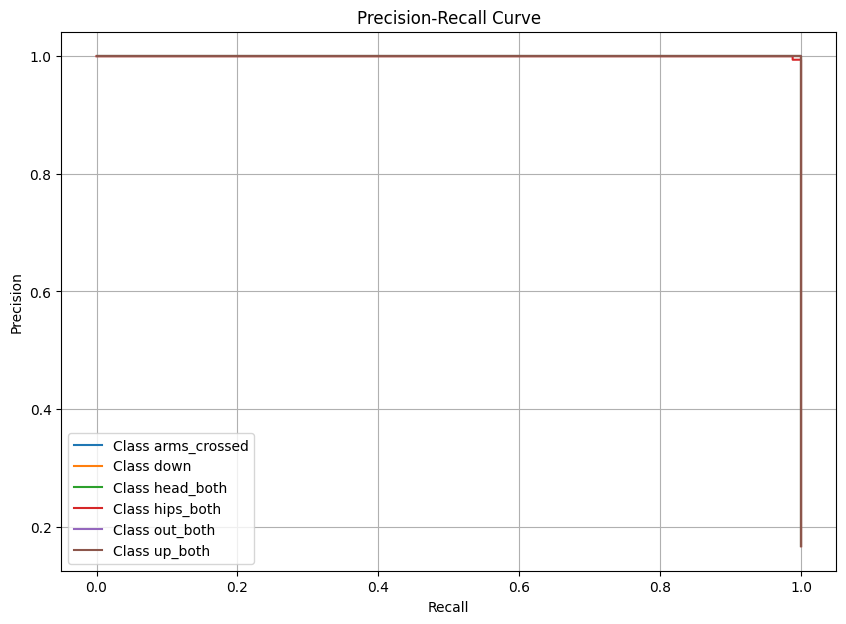

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


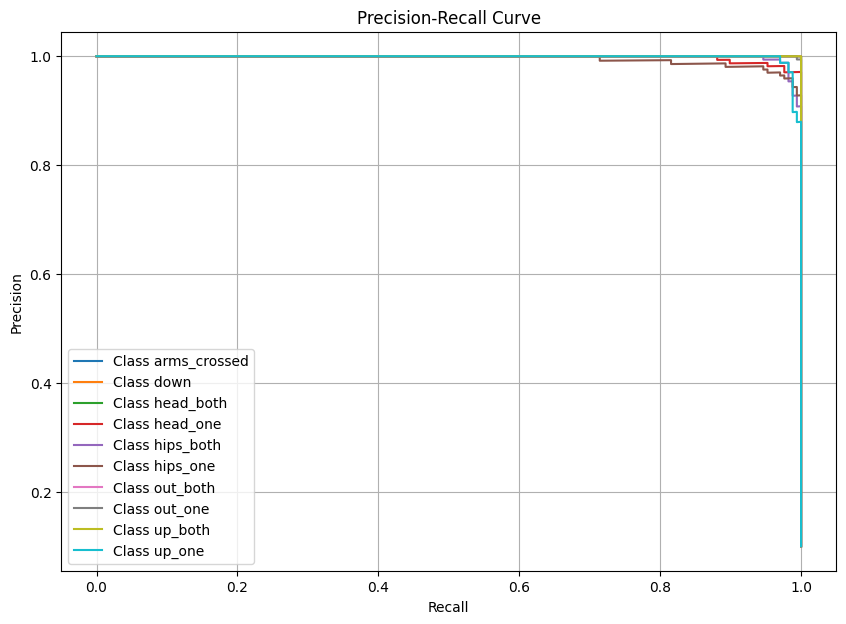

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


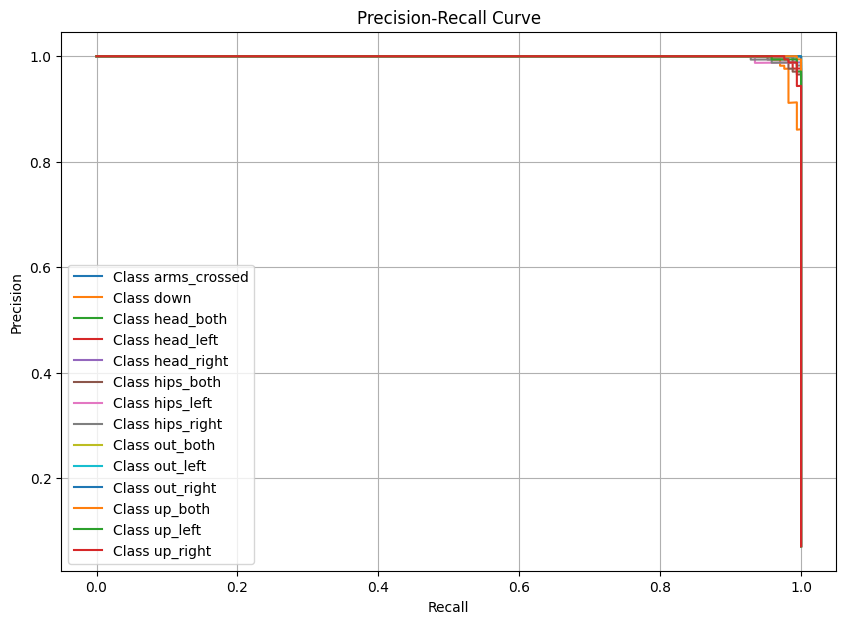

In [50]:
plot_precision_recall(best_model_both, X_both_test, y_both_test, label_encoder_both.classes_)

plot_precision_recall(best_model_agnostic, X_agnostic_test, y_agnostic_test, label_encoder_agnostic.classes_)

plot_precision_recall(best_model_cognizant, X_cognizant_test, y_cognizant_test, label_encoder_cognizant.classes_)

### Confusion Matrices

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def get_confusion_matrix(model, X_test, y_test, label_encoder, title="Confusion Matrix"):
    """
    Evaluate the model on the test set and generate a confusion matrix.
    Args:
        model: Trained model.
        X_test: Test features.
        y_test: One-hot encoded test labels.
        label_encoder: LabelEncoder used for encoding the labels.
        title: Title for the confusion matrix plot.
    """
    # Convert one-hot encoded labels back to integers
    y_true = np.argmax(y_test, axis=1)

    # Predict and convert predictions to integers
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print classification report
    print(f"{title} - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Both-Hands Classifier - Confusion Matrix - Classification Report:
              precision    recall  f1-score   support

arms_crossed       1.00      1.00      1.00       168
        down       1.00      0.99      0.99       168
   head_both       1.00      1.00      1.00       168
   hips_both       0.99      1.00      0.99       168
    out_both       1.00      1.00      1.00       168
     up_both       1.00      1.00      1.00       168

    accuracy                           1.00      1008
   macro avg       1.00      1.00      1.00      1008
weighted avg       1.00      1.00      1.00      1008



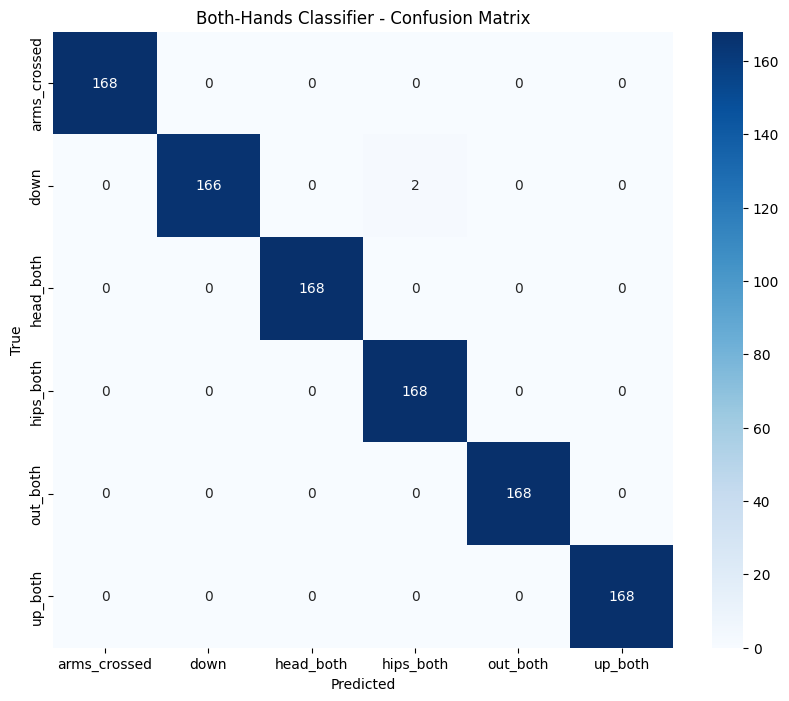

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Direction-Agnostic Classifier - Confusion Matrix - Classification Report:
              precision    recall  f1-score   support

arms_crossed       1.00      1.00      1.00       168
        down       0.98      1.00      0.99       168
   head_both       1.00      1.00      1.00       168
    head_one       0.97      0.99      0.98       168
   hips_both       0.99      0.96      0.98       168
    hips_one       0.96      0.98      0.97       168
    out_both       1.00      0.99      1.00       168
     out_one       0.99      1.00      1.00       168
     up_both       1.00      1.00      1.00       168
      up_one       0.99      0.97      0.98       168

    accuracy                           0.99      1680
   macro avg       0.99      0.99      0.99      1680
weighted avg       0.99      0.99      0.99      1680



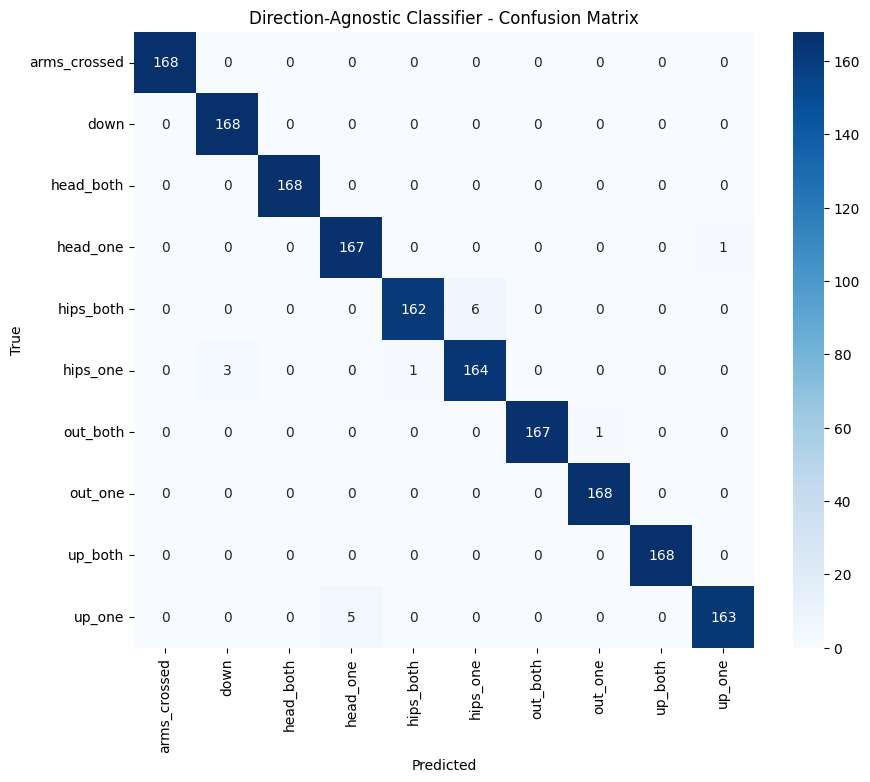

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Direction-Cognizant Classifier - Confusion Matrix - Classification Report:
              precision    recall  f1-score   support

arms_crossed       1.00      1.00      1.00       168
        down       0.98      0.98      0.98       168
   head_both       0.99      1.00      0.99       168
   head_left       0.99      0.99      0.99       168
  head_right       0.98      1.00      0.99       168
   hips_both       0.99      0.98      0.98       168
   hips_left       0.98      0.99      0.99       168
  hips_right       0.98      0.99      0.99       168
    out_both       1.00      1.00      1.00       168
    out_left       0.99      1.00      1.00       168
   out_right       1.00      1.00      1.00       168
     up_both       1.00      0.99      1.00       168
     up_left       0.99      0.99      0.99       168
    up_right       1.00      0.97      0.98       168

    accuracy                           0.99      2352
   macro avg       0

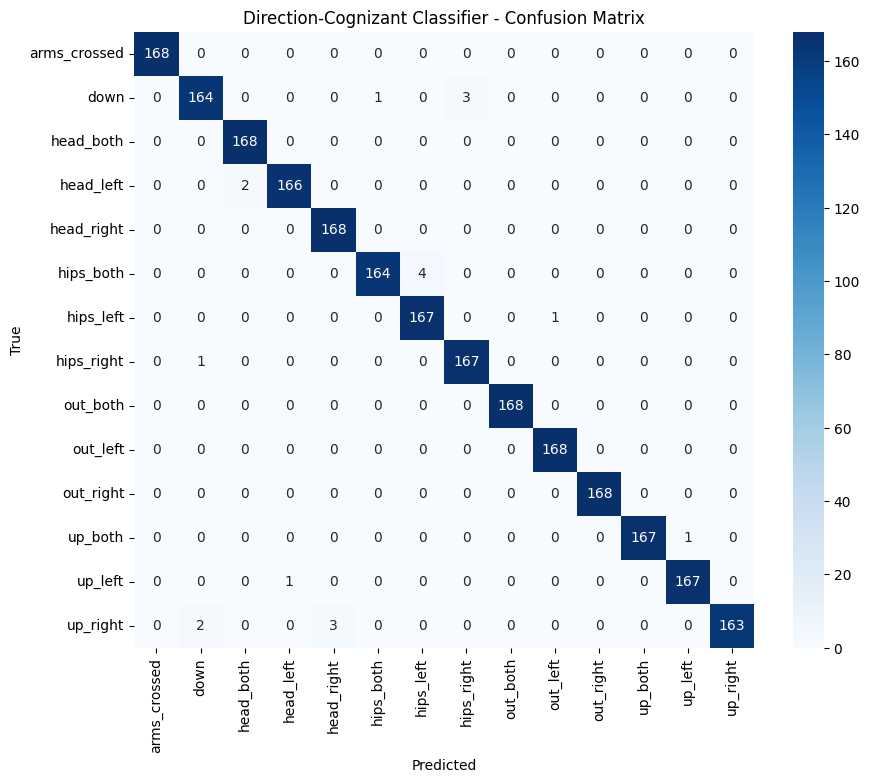

In [52]:
# Get the confusion matrix for the Both-Hands Classifier
get_confusion_matrix(
    model=best_model_both,
    X_test=X_both_test,
    y_test=y_both_test,
    label_encoder=label_encoder_both,
    title="Both-Hands Classifier - Confusion Matrix"
)

# Get the confusion matrix for the Direction-Agnostic Classifier
get_confusion_matrix(
    model=best_model_agnostic,
    X_test=X_agnostic_test,
    y_test=y_agnostic_test,
    label_encoder=label_encoder_agnostic,
    title="Direction-Agnostic Classifier - Confusion Matrix"
)

# Get the confusion matrix for the Direction-Cognizant Classifier
get_confusion_matrix(
    model=best_model_cognizant,
    X_test=X_cognizant_test,
    y_test=y_cognizant_test,
    label_encoder=label_encoder_cognizant,
    title="Direction-Cognizant Classifier - Confusion Matrix"
)

## Explainability Investigation with SHAP

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shap

In [54]:
feature_names = pose_data_both_hands.filter(like='keypoint').columns.tolist()
print("Available feature names:", feature_names)


Available feature names: ['keypoint_1_x', 'keypoint_1_y', 'keypoint_1_confidence', 'keypoint_2_x', 'keypoint_2_y', 'keypoint_2_confidence', 'keypoint_3_x', 'keypoint_3_y', 'keypoint_3_confidence', 'keypoint_4_x', 'keypoint_4_y', 'keypoint_4_confidence', 'keypoint_5_x', 'keypoint_5_y', 'keypoint_5_confidence', 'keypoint_6_x', 'keypoint_6_y', 'keypoint_6_confidence', 'keypoint_7_x', 'keypoint_7_y', 'keypoint_7_confidence', 'keypoint_8_x', 'keypoint_8_y', 'keypoint_8_confidence', 'keypoint_9_x', 'keypoint_9_y', 'keypoint_9_confidence', 'keypoint_10_x', 'keypoint_10_y', 'keypoint_10_confidence', 'keypoint_11_x', 'keypoint_11_y', 'keypoint_11_confidence', 'keypoint_12_x', 'keypoint_12_y', 'keypoint_12_confidence', 'keypoint_13_x', 'keypoint_13_y', 'keypoint_13_confidence', 'keypoint_14_x', 'keypoint_14_y', 'keypoint_14_confidence', 'keypoint_15_x', 'keypoint_15_y', 'keypoint_15_confidence', 'keypoint_16_x', 'keypoint_16_y', 'keypoint_16_confidence', 'keypoint_17_x', 'keypoint_17_y', 'keypoi

In [55]:
def visualize_test_samples(X_test, image_paths, num_samples=10, grid_shape=(5, 2)):
    """
    Visualize the test samples with corresponding images in a grid.
    Args:
        X_test: Feature matrix (not directly used here for visualization).
        image_paths: List of file paths to the images corresponding to the samples.
        num_samples: Number of samples to visualize.
        grid_shape: Tuple specifying the grid layout (rows, columns).
    """
    rows, cols = grid_shape
    assert rows * cols >= num_samples, "Grid size is smaller than the number of samples to display!"

    # Create a figure for the visualization
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten axes for easy indexing
    
    for i in range(rows * cols):
        if i < num_samples:
            # Load the image using OpenCV
            img = cv2.imread(image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            # Display the image
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Sample {i+1}")
        else:
            # Hide any extra subplots
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

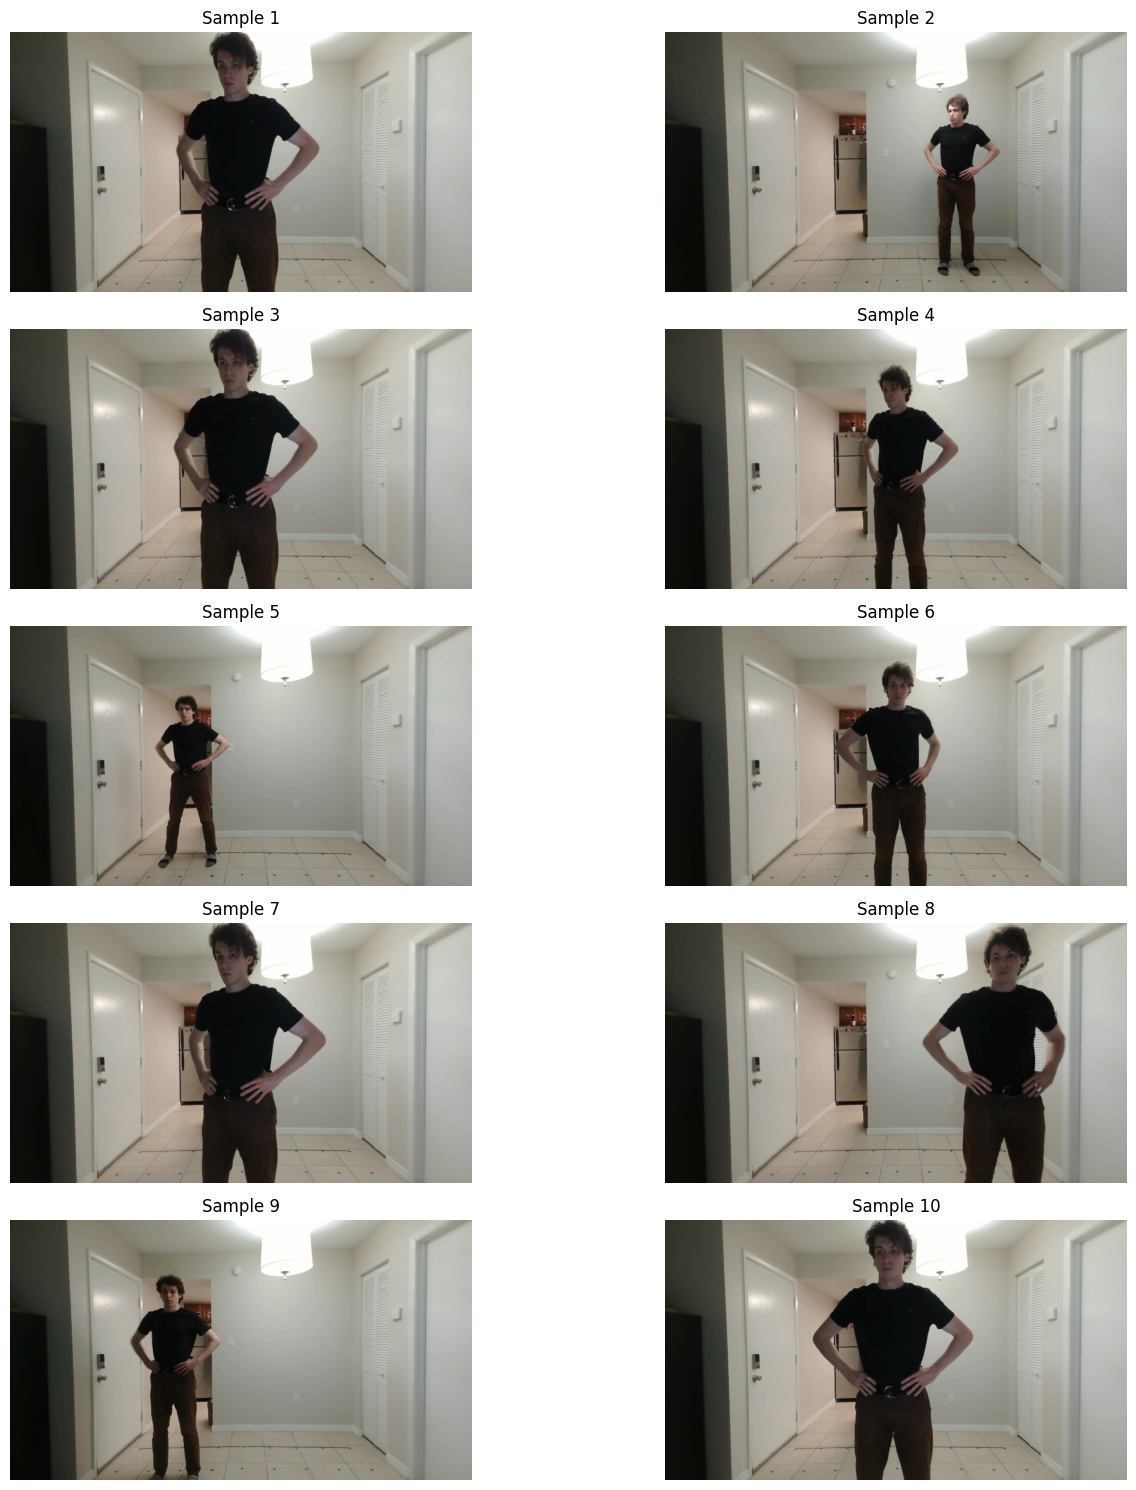

In [56]:
# Isolating the image paths and visualizing test samples
image_paths = pose_data_both_hands['filepath'].values 
visualize_test_samples(X_both_test, image_paths, num_samples=10, grid_shape=(5, 2))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


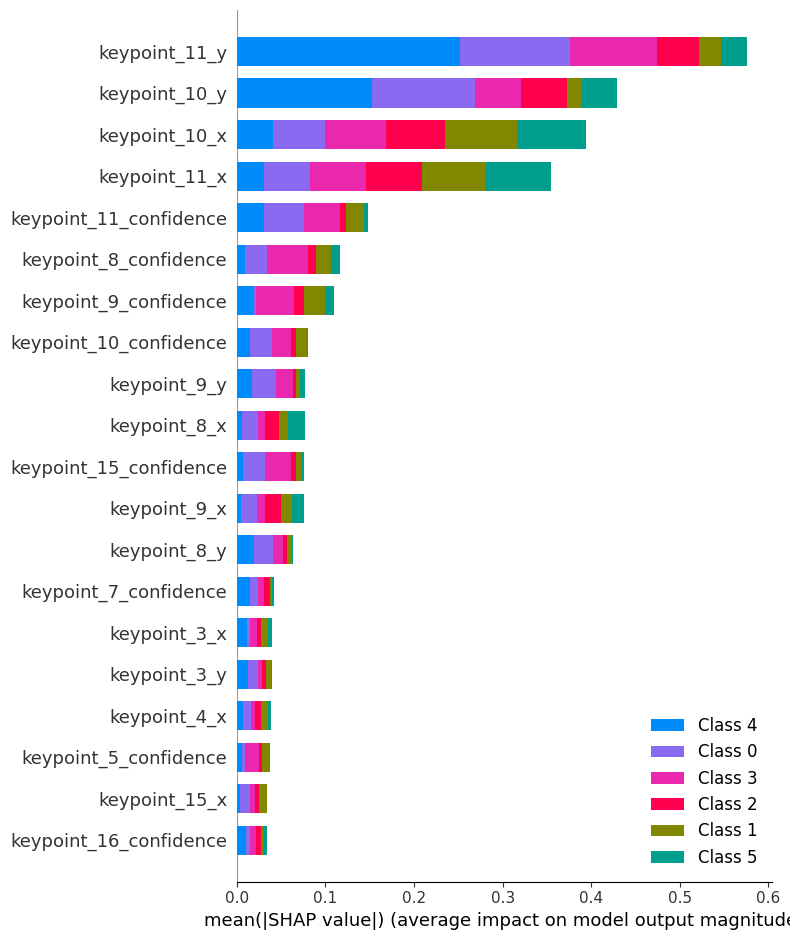

In [57]:
# Set up SHAP KernelExplainer
explainer_both = shap.KernelExplainer(best_model_both.predict, X_both_train[:100])  # Use a small subset of the training data as the background

# Explain the first 10 samples from the test set
shap_values_both = explainer_both.shap_values(X_both_test[:10])

# Plot summary of feature importance
shap.summary_plot(shap_values_both, X_both_test[:10], feature_names=pose_data_both_hands.filter(like='keypoint').columns)

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


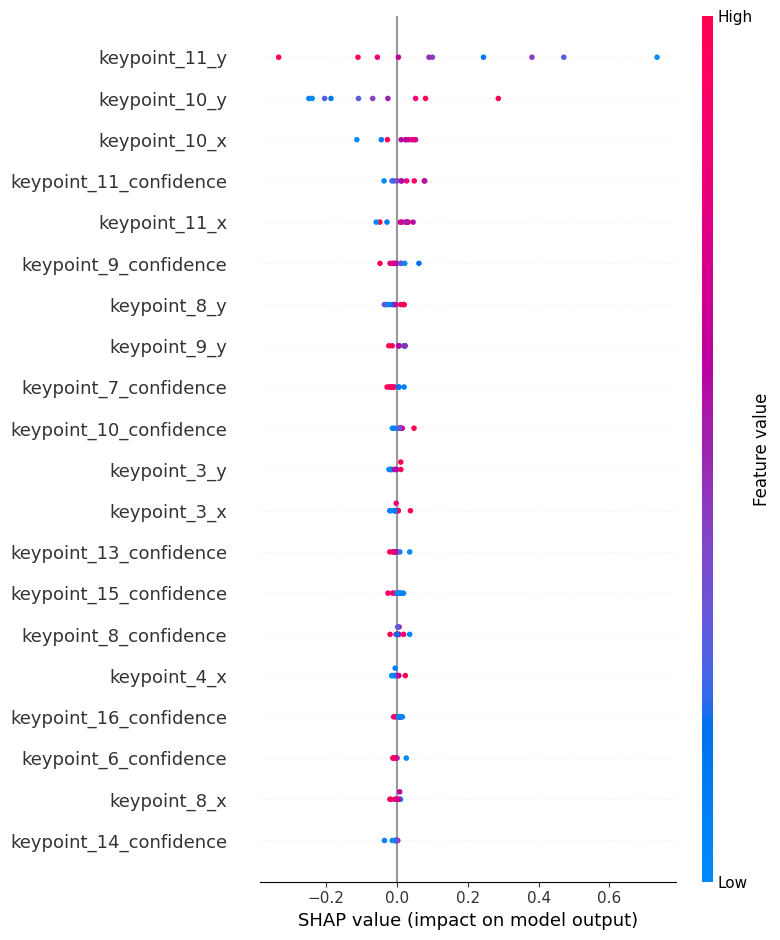

In [58]:
# Specifying the output index (i.e. class) to 4
# since the test set snippet showed hands on hips
output_index = 4

# Compute SHAP values for the specified output index
shap_values_both = explainer_both.shap_values(X_both_test[:10])[output_index]

# Plot summary of feature importance
shap.summary_plot(shap_values_both, X_both_test[:10], feature_names=pose_data_both_hands.filter(like='keypoint').columns)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


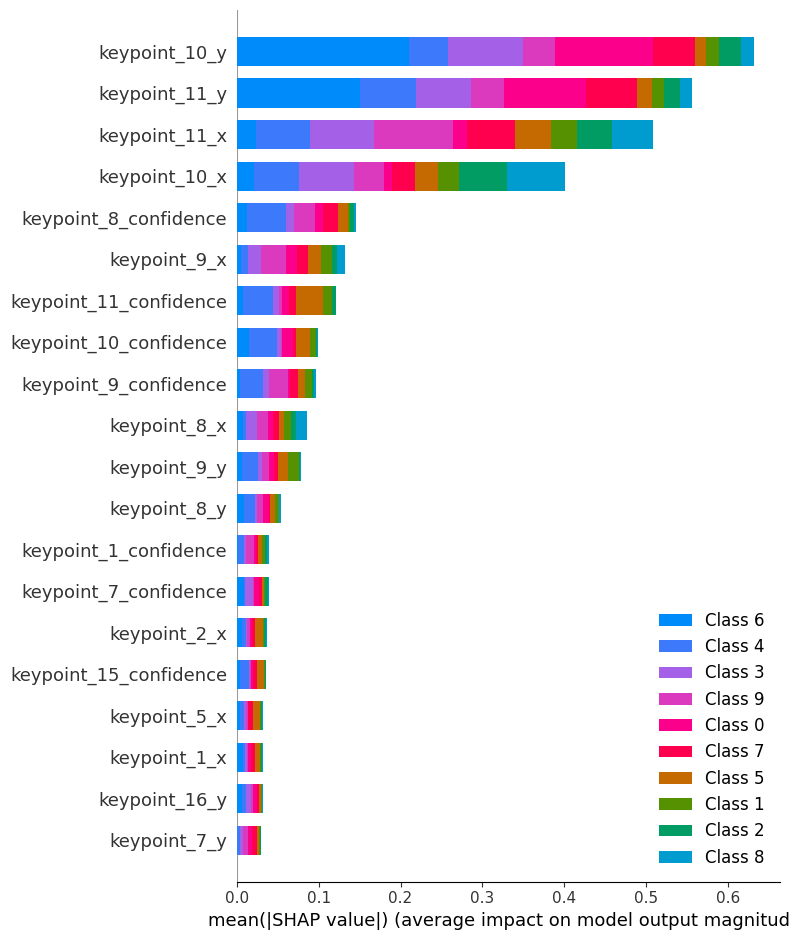

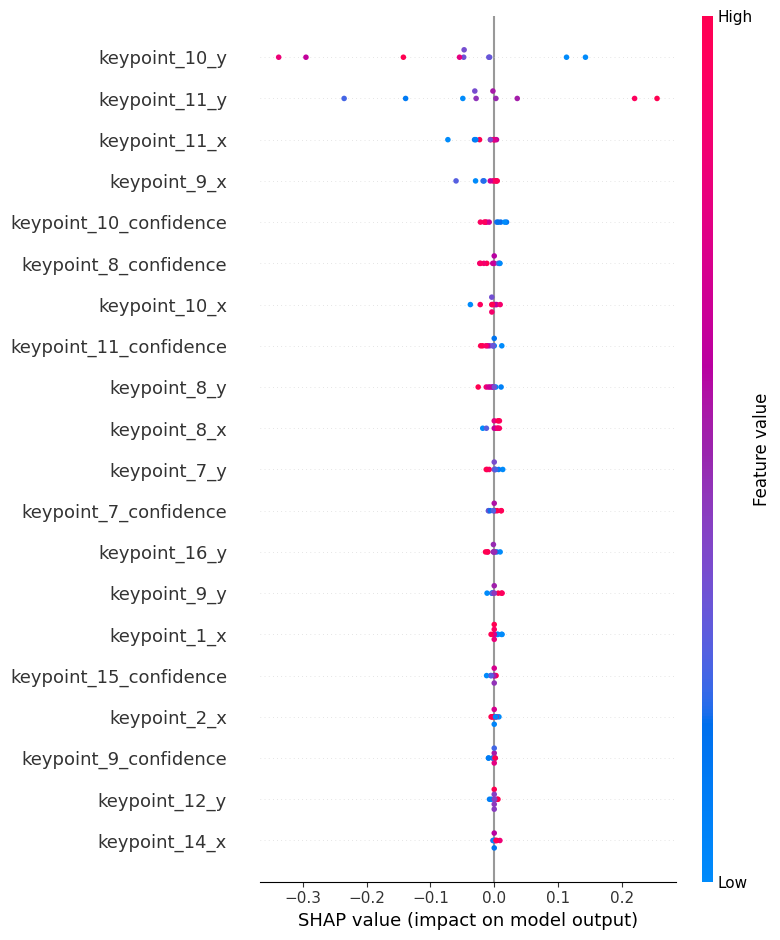

In [59]:
# Set up SHAP KernelExplainer for the agnostic classifier
explainer_agnostic = shap.KernelExplainer(best_model_agnostic.predict, X_agnostic_train[:100])

# Explain the first 10 samples from the test set for all classes
shap_values_agnostic = explainer_agnostic.shap_values(X_agnostic_test[:10])

# Summary plot for all classes
shap.summary_plot(
    shap_values_agnostic,
    X_agnostic_test[:10],
    feature_names=pose_data_agnostic.filter(like='keypoint').columns
)

# Specify the output index (e.g., class index 0)
output_index = 0

# Compute SHAP values for the specified output index
shap_values_agnostic_specific = shap_values_agnostic[output_index]

# Summary plot for a specific class
shap.summary_plot(
    shap_values_agnostic_specific,
    X_agnostic_test[:10],
    feature_names=pose_data_agnostic.filter(like='keypoint').columns
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


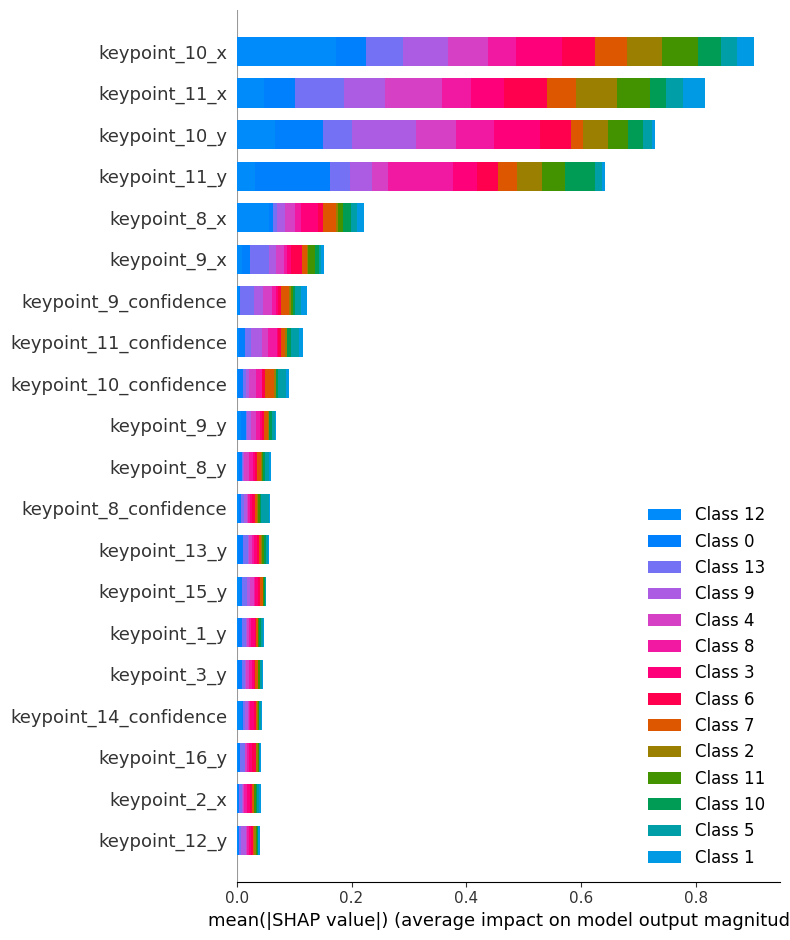

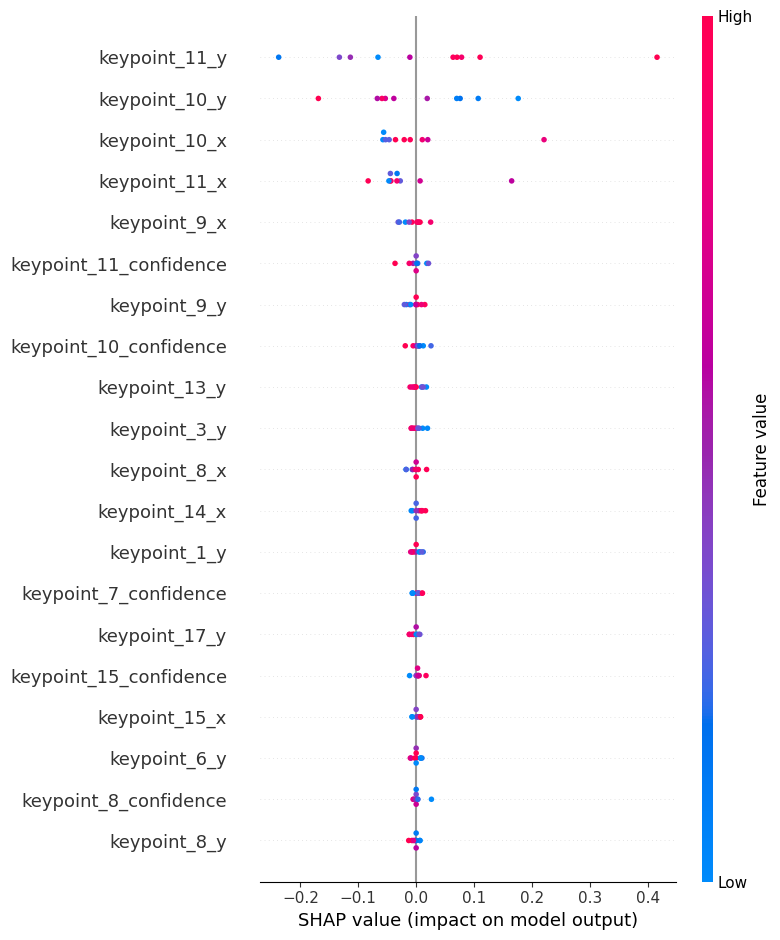

In [60]:
# Set up SHAP KernelExplainer for the cognizant classifier
explainer_cognizant = shap.KernelExplainer(best_model_cognizant.predict, X_cognizant_train[:100])

# Explain the first 10 samples from the test set for all classes
shap_values_cognizant = explainer_cognizant.shap_values(X_cognizant_test[:10])

# Summary plot for all classes
shap.summary_plot(
    shap_values_cognizant,
    X_cognizant_test[:10],
    feature_names=pose_data_cognizant.filter(like='keypoint').columns
)

# Specify the output index (e.g., class index 0)
output_index = 0

# Compute SHAP values for the specified output index
shap_values_cognizant_specific = shap_values_cognizant[output_index]

# Summary plot for a specific class
shap.summary_plot(
    shap_values_cognizant_specific,
    X_cognizant_test[:10],
    feature_names=pose_data_cognizant.filter(like='keypoint').columns
)